# AdventureWorks – Försäljningsanalys

## Introduktion

Syftet med denna analys är att undersöka försäljningsdata från AdventureWorks-databasen för att få insikter om företagets produkter, försäljningsutveckling och kundbeteenden.  
Genom att använda SQL Server för datahämtning och Python för bearbetning och visualisering analyseras försäljning ur flera perspektiv, såsom produktkategorier, tidsutveckling, regioner och kundtyper.

Målet med analysen är att besvara affärsrelaterade frågor och presentera resultaten i tydliga visualiseringar som kan ligga till grund för bättre affärsbeslut.


In [3]:
import pandas as pd 
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, text
from urllib.parse import quote_plus

user = "SA"
password = quote_plus("sqlserver123!")
server = 'localhost,1434'
database = 'AdventureWorks'
driver = quote_plus("ODBC Driver 18 for SQL server")


connection_string = (
    f"mssql+pyodbc://{user}:{password}@{server}/{database}"
    f"?driver={driver}&Encrypt=yes&TrustServerCertificate=yes"
)

engine = create_engine(connection_string)


try:
    with engine.connect():
        print("Anslutning till SQL Server lyckades")
except Exception as e:
    print("Kunde inte ansluta", e)

Anslutning till SQL Server lyckades


C:\Users\danie\AppData\Local\Temp\ipykernel_27864\3540106384.py:22: SAWarning: Unrecognized server version info '17.0.1000.7'.  Some SQL Server features may not function properly.
  with engine.connect():


In [4]:
def query_df(sql: str):
    with engine.connect() as conn:
        return pd.read_sql(text(sql), conn)

# Visualisering 1: Antal produkter per kategori
Hur många produkter finns i varje kategori?

**Metod:**
Data har hämtats från tabellerna `Production.ProductCategory`, `Production.ProductSubcategory` och `Production.Product`. Antalet unika produkter har beräknats per kategori med `COUNT(DISTINCT ProductID)` och grupperats på `ProductCategory.Name`.


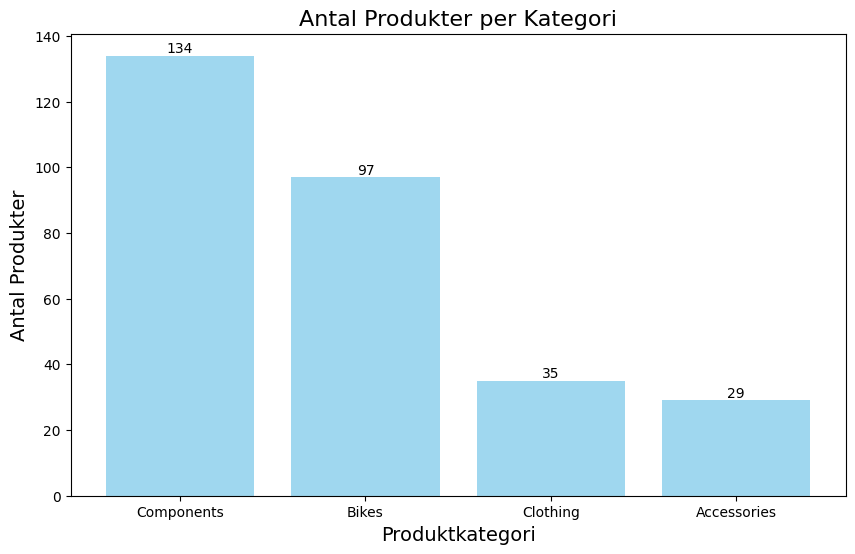

In [5]:
query_vis1 = """

SELECT pc.Name AS CategoryName,
       COUNT(DISTINCT p.ProductID) AS ProductCount

FROM Production.ProductCategory pc
INNER JOIN Production.ProductSubcategory psc ON pc.ProductCategoryID = psc.ProductCategoryID
INNER JOIN Production.Product p ON psc.ProductSubcategoryID = p.ProductSubcategoryID
GROUP BY pc.Name
ORDER BY ProductCount DESC;
"""

df_vis1 = query_df(query_vis1)


fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(df_vis1['CategoryName'], df_vis1['ProductCount'], color='skyblue', alpha = 0.8)

for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{int(bar.get_height())}",
        ha='center',
        va='bottom'
    )
 

ax.set_xlabel('Produktkategori', fontsize=14)
ax.set_ylabel('Antal Produkter', fontsize=14)
ax.set_title('Antal Produkter per Kategori', fontsize=16)
plt.show()


**Insikt:**
Components är kategorin med högst antal unika produkter på 134 st. Accessories är lägst med 29 st.

# Visualisering 2:  Försäljning per produktkategori
Vilka produktkategorier genererar mest intäkter?

**Metod:**
Försäljningsdata har hämtats genom att koppla `Production.ProductCategory`, `Production.ProductSubcategory` och `Production.Product` till `Sales.SalesOrderDetail` via `ProductID`. Total försäljning per kategori har beräknats genom `SUM(LineTotal)` och grupperats på `ProductCategory.Name`.


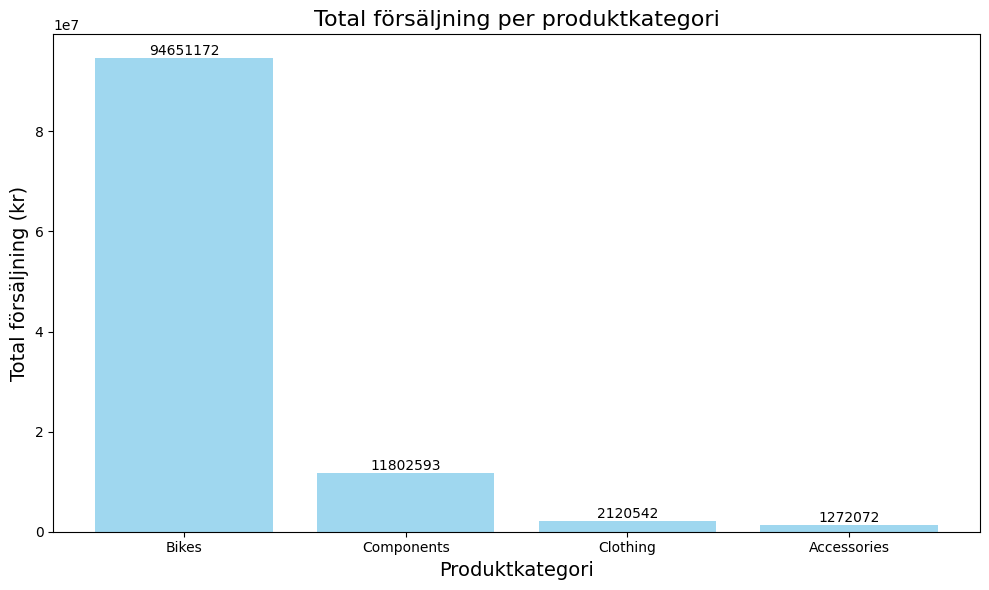

In [6]:
query_vis2 = """ 
SELECT 
    pc.Name AS CategoryName,
    SUM(sod.LineTotal) AS TotalSales
FROM Production.ProductCategory pc
INNER JOIN Production.ProductSubcategory psc
    ON pc.ProductCategoryID = psc.ProductCategoryID
INNER JOIN Production.Product p
    ON psc.ProductSubcategoryID = p.ProductSubcategoryID
INNER JOIN Sales.SalesOrderDetail sod
    ON p.ProductID = sod.ProductID
GROUP BY pc.Name
ORDER BY TotalSales DESC;
"""

df_vis2 = query_df(query_vis2)


fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(df_vis2['CategoryName'], df_vis2['TotalSales'], color='skyblue', alpha = 0.8)

for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{int(bar.get_height())}",
        ha='center',
        va='bottom'
    )
 

ax.set_xlabel('Produktkategori', fontsize=14)
ax.set_ylabel('Total försäljning (kr)', fontsize=14)
ax.set_title('Total försäljning per produktkategori', fontsize=16)

plt.tight_layout()
plt.show()

**Insikt:**

Bikes är den produktkategori som genererar mest försäljning med totalt 94 651 172 kronor, vilket visar att cyklar är företagets viktigaste intäktskälla.
Accessories har lägst försäljning med 1 272 072 kronor, vilket indikerar att tillbehör spelar en mindre roll i intäktsstrukturen jämfört med övriga kategorier.


# Visualisering 3: Försäljningstrend över tid

 Hur har försäljningen utvecklats över tid?

**Metod:**
Data har hämtats från `Sales.SalesOrderHeader`. Försäljningen har aggregerats per månad baserat på `OrderDate` genom att gruppera på år och månad (`YEAR(OrderDate)`, `MONTH(OrderDate)`) och summera `TotalDue`.


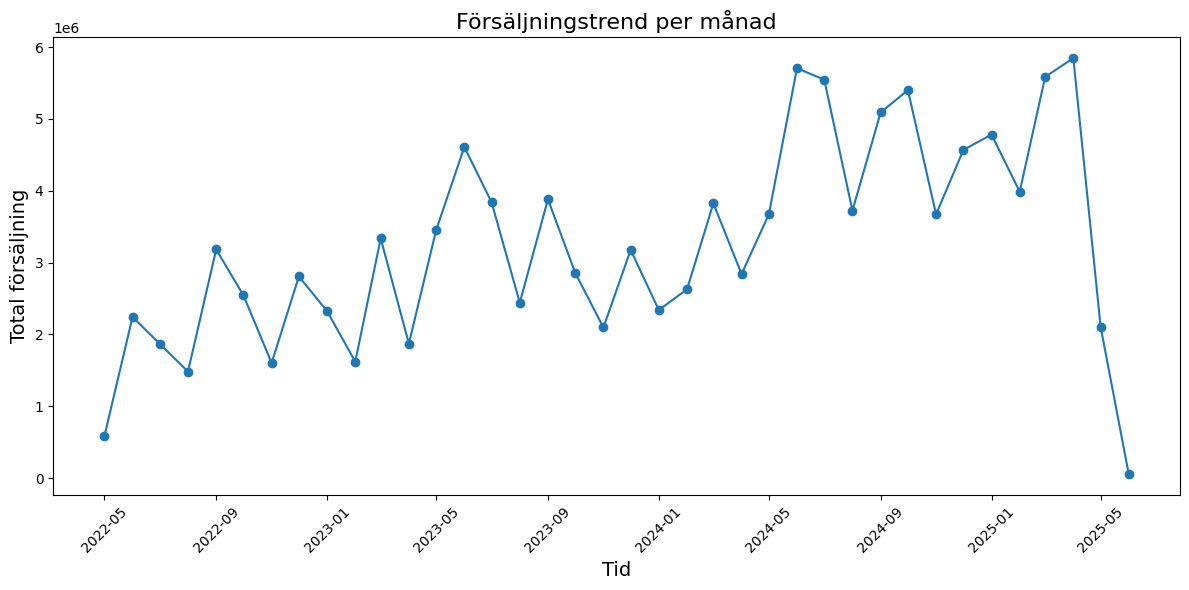

In [7]:
query_vis3 = """

SELECT 
    YEAR(OrderDate) AS OrderYear,
    MONTH(OrderDate) AS OrderMonth,
    DATENAME(MONTH, OrderDate) AS MonthName,
    SUM(TotalDue) AS TotalSales
FROM Sales.SalesOrderHeader
GROUP BY 
    YEAR(OrderDate),
    MONTH(OrderDate),
    DATENAME(MONTH, OrderDate)
ORDER BY 
    OrderYear,
    OrderMonth;

"""


df_vis3 = query_df(query_vis3)


df_vis3['Date'] = pd.to_datetime(
    df_vis3['OrderYear'].astype(str) + '-' +
    df_vis3['OrderMonth'].astype(str) + '-01'
)


df_vis3 = df_vis3.sort_values('Date')


fig, ax = plt.subplots(figsize=(12, 6))


ax.plot(
    df_vis3['Date'],
    df_vis3['TotalSales'],
    marker='o'
)


ax.set_title('Försäljningstrend per månad', fontsize=16)
ax.set_xlabel('Tid', fontsize=14)
ax.set_ylabel('Total försäljning', fontsize=14)

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()






**Insikt:**

Diagrammet visar att försäljningen överlag har en ökande trend över tid.
Den högsta försäljningen sker under Maj månad år 2025, medan den lägsta noteras under Maj månad år 2022.
Detta indikerar att försäljningen inte är jämnt fördelad över året. Men runt Maj månad brukar det gå som bäst.


# Visualisering 4: Försäljning och antal ordrar per år

Hur ser total försäljning och antal ordrar ut per år?

**Metod:**
Orderdata har hämtats från `Sales.SalesOrderHeader` och grupperats per år med `YEAR(OrderDate)`. Total försäljning har beräknats med `SUM(TotalDue)` och antal ordrar med `COUNT(SalesOrderID)`.



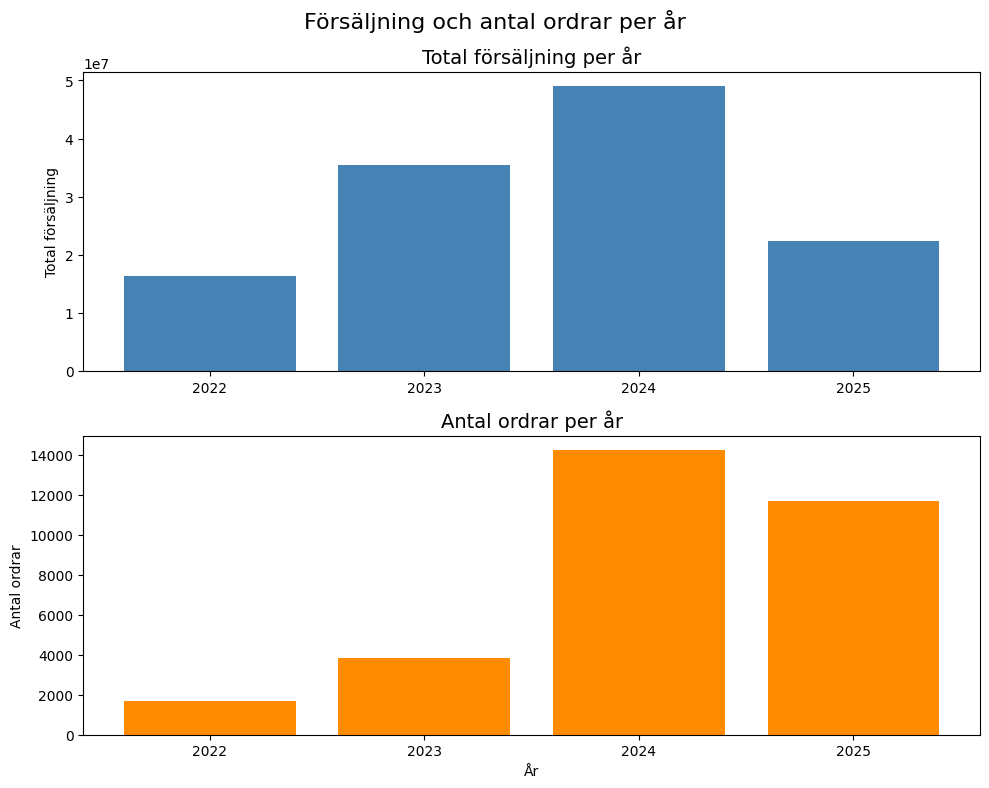

In [8]:
query_vis4 = """
SELECT 
    YEAR(OrderDate) AS OrderYear,
    SUM(TotalDue) AS TotalSales,
    COUNT(SalesOrderID) AS OrderCount
FROM Sales.SalesOrderHeader
GROUP BY YEAR(OrderDate)
ORDER BY OrderYear;
"""

df_vis4 = query_df(query_vis4)

fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Diagram 1: Total försäljning per år
axes[0].bar(df_vis4['OrderYear'], df_vis4['TotalSales'], color='steelblue')
axes[0].set_title('Total försäljning per år', fontsize=14)
axes[0].set_ylabel('Total försäljning')
axes[0].tick_params(axis='x', labelbottom=True)

# Diagram 2: Antal ordrar per år
axes[1].bar(df_vis4['OrderYear'], df_vis4['OrderCount'], color='darkorange')
axes[1].set_title('Antal ordrar per år', fontsize=14)
axes[1].set_ylabel('Antal ordrar')
axes[1].set_xlabel('År')

# 🔹 Tvinga helår på x-axeln
axes[1].set_xticks(df_vis4['OrderYear'])

fig.suptitle('Försäljning och antal ordrar per år', fontsize=16)

plt.tight_layout()
plt.show()



**Insikt:**

År 2024 har den högsta totala försäljningen.
Både försäljningen och antalet ordrar ökar över tid, vilket indikerar en tydlig tillväxt i verksamheten.
Ökningen i försäljning är större än ökningen i antal ordrar, vilket tyder på att det genomsnittliga ordervärdet har ökat.


# Visualisering 5: Top 10 produkter

Vilka 10 produkter genererar mest försäljning?

**Metod:**
Försäljningsvärdet har beräknats per produkt genom att koppla `Production.Product` till `Sales.SalesOrderDetail` via `ProductID`. Total försäljning per produkt har summerats med `SUM(LineTotal)` och de 10 produkter med högst försäljning har valts ut.


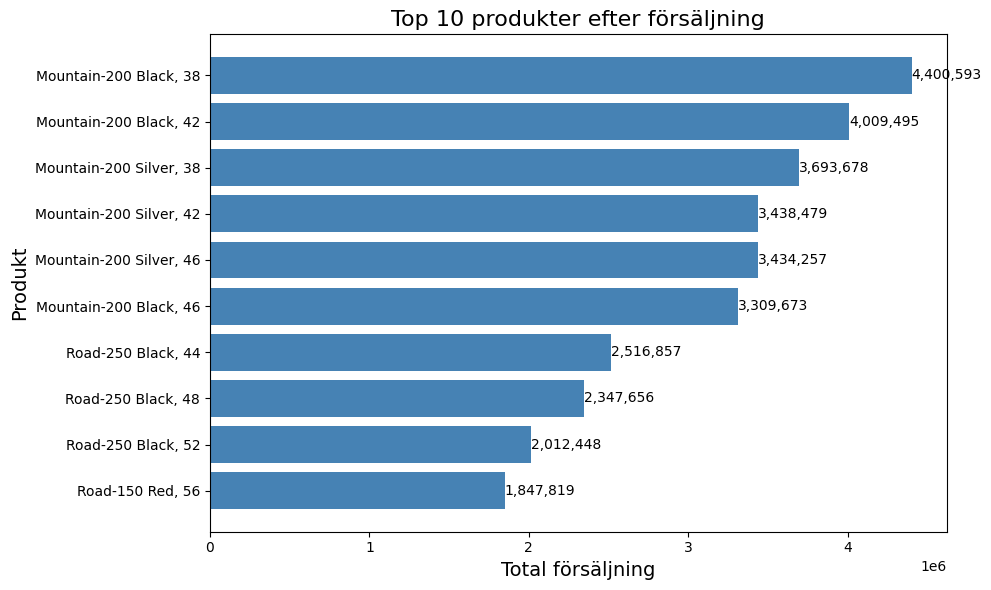

In [9]:
query_vis5 = """
SELECT TOP 10
    p.Name AS ProductName,
    SUM(sod.LineTotal) AS TotalSales
FROM Production.Product p
INNER JOIN Sales.SalesOrderDetail sod
    ON p.ProductID = sod.ProductID
GROUP BY p.Name
ORDER BY TotalSales DESC;
"""
df_vis5 = query_df(query_vis5)

# Säkerställ rätt sortering för barh (högst överst)
df_vis5 = df_vis5.sort_values('TotalSales', ascending=True)

fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.barh(
    df_vis5['ProductName'],
    df_vis5['TotalSales'],
    color='steelblue'
)

# Lägg till värden på staplarna
for bar in bars:
    width = bar.get_width()
    ax.text(
        width,
        bar.get_y() + bar.get_height() / 2,
        f"{width:,.0f}",
        va='center'
    )

ax.set_xlabel('Total försäljning', fontsize=14)
ax.set_ylabel('Produkt', fontsize=14)
ax.set_title('Top 10 produkter efter försäljning', fontsize=16)

plt.tight_layout()
plt.show()





**Insikt:**

Den produkt som genererar mest försäljning är Mountain 200 Black 38 med ett totalt försäljningsvärde på 
4,4 miljoner.
Topplistan domineras till stor del av produkter inom samma kategori, vilket indikerar att denna kategori är särskilt viktig för företagets intäkter. Denna kategori är då Bikes, speciellt av typen Mountain-200 som verkar var drivande i försäljningen totalt.


# Visualisering 6: Försäljning och antal kunder per region

 Hur skiljer sig försäljningen mellan olika regioner, och hur många unika kunder har varje region?

 **Metod:**
Data har hämtats från `Sales.SalesTerritory`, `Sales.SalesOrderHeader` och `Sales.Customer`. Total försäljning per region har beräknats med `SUM(TotalDue)` och antal unika kunder med `COUNT(DISTINCT CustomerID)`, grupperat på `SalesTerritory.Name`.


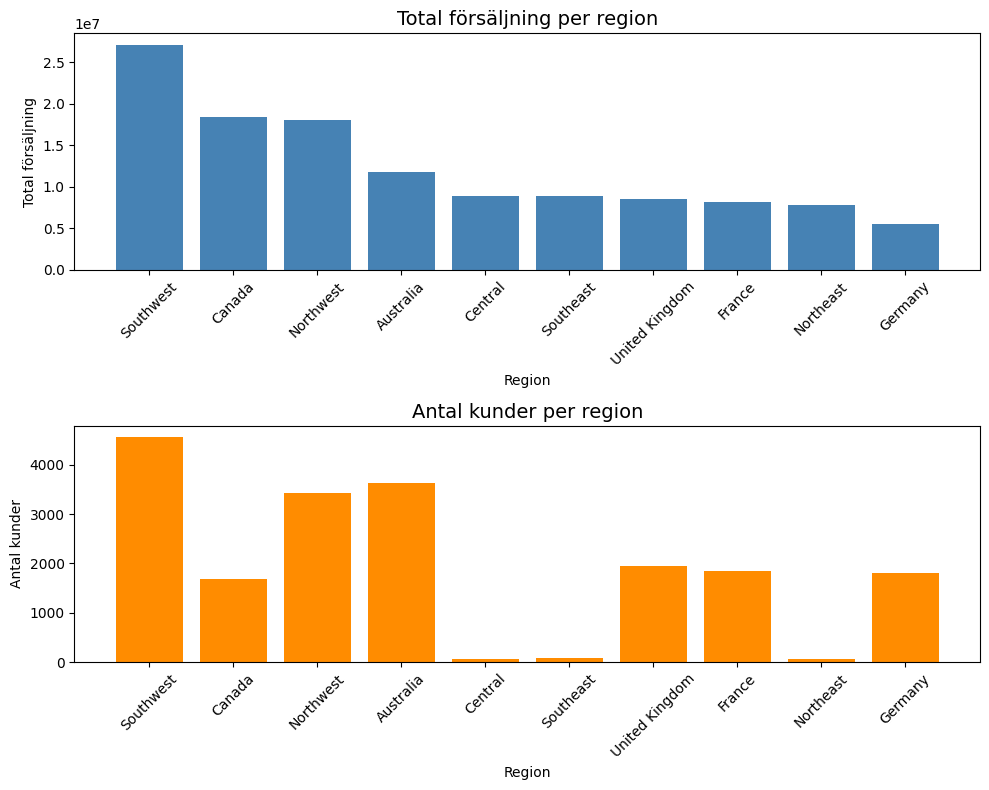

In [10]:
query_vis6 = """
SELECT
    st.Name AS Region,
    SUM(soh.TotalDue) AS TotalSales,
    COUNT(DISTINCT soh.CustomerID) AS CustomerCount
FROM Sales.SalesTerritory st
INNER JOIN Sales.SalesOrderHeader soh
    ON st.TerritoryID = soh.TerritoryID
INNER JOIN Sales.Customer c
    ON soh.CustomerID = c.CustomerID
GROUP BY st.Name
ORDER BY TotalSales DESC;

"""

df_vis6 = query_df(query_vis6)

fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Diagram 1 – Total försäljning
axes[0].bar(
    df_vis6['Region'],
    df_vis6['TotalSales'],
    color='steelblue'
)
axes[0].set_title('Total försäljning per region', fontsize=14)
axes[0].set_ylabel('Total försäljning')
axes[0].set_xlabel('Region')
axes[0].tick_params(axis='x', labelbottom=True, rotation=45)



# Diagram 2 – Antal kunder
axes[1].bar(
    df_vis6['Region'],
    df_vis6['CustomerCount'],
    color='darkorange'
)
axes[1].set_title('Antal kunder per region', fontsize=14)
axes[1].set_ylabel('Antal kunder')
axes[1].set_xlabel('Region')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()





**Insikt:**

Regionen X har den högsta totala försäljningen, medan regionen Y har den lägsta.
X har inte nödvändigtvis flest kunder, vilket tyder på att försäljningen där drivs av högre genomsnittligt ordervärde snarare än kundvolym.
Regioner med många kunder men lägre total försäljning indikerar istället en mer volymbaserad marknad.


# Visualisering 7: Genomsnittligt ordervärde per region och kundtyp

Vilka regioner har högst/lägst genomsnittligt ordervärde, och skiljer det sig mellan individuella kunder och företagskunder?

**Metod:**
Orderdata har hämtats från `Sales.SalesOrderHeader`, `Sales.SalesTerritory` och `Sales.Customer`. Kundtyp har identifierats via `Sales.Customer.StoreID` (Store respektive Individual). Genomsnittligt ordervärde har beräknats som `SUM(TotalDue) / COUNT(SalesOrderID)` och grupperats per region och kundtyp.


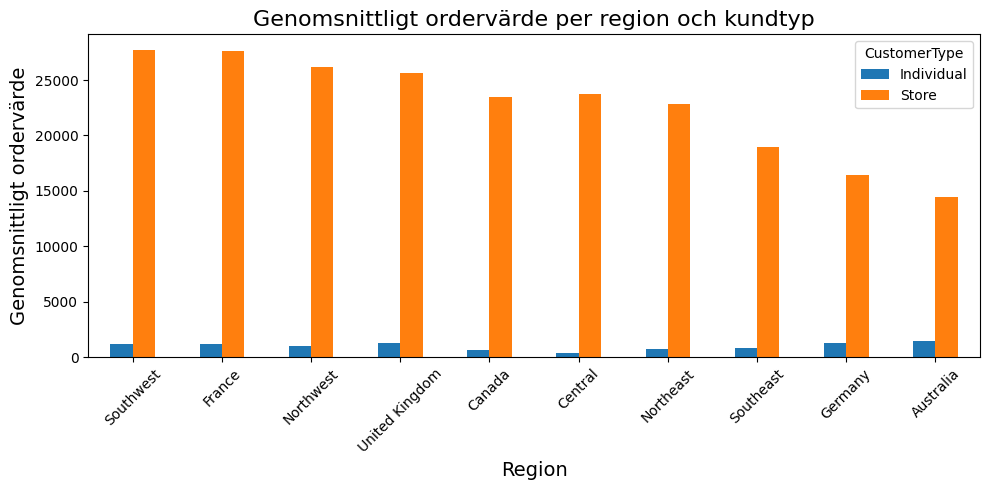

In [11]:
query_vis7 = """
SELECT
    st.Name AS Region,
    CASE 
        WHEN c.StoreID IS NOT NULL THEN 'Store'
        ELSE 'Individual'
    END AS CustomerType,
    SUM(soh.TotalDue) AS TotalSales,
    COUNT(soh.SalesOrderID) AS OrderCount,
    SUM(soh.TotalDue) / COUNT(soh.SalesOrderID) AS AvgOrderValue
FROM Sales.SalesOrderHeader soh
INNER JOIN Sales.SalesTerritory st
    ON soh.TerritoryID = st.TerritoryID
INNER JOIN Sales.Customer c
    ON soh.CustomerID = c.CustomerID
GROUP BY 
    st.Name,
    CASE 
        WHEN c.StoreID IS NOT NULL THEN 'Store'
        ELSE 'Individual'
    END
ORDER BY Region, CustomerType;
"""

df_vis7 = query_df(query_vis7)

# Pivotera för att få Store och Individual som kolumner
pivot_df = df_vis7.pivot(
    index='Region',
    columns='CustomerType',
    values='AvgOrderValue'
)

# Sortera regioner efter högst genomsnittligt ordervärde (total)
pivot_df['TotalAvg'] = pivot_df.mean(axis=1)
pivot_df = pivot_df.sort_values('TotalAvg', ascending=False)
pivot_df = pivot_df.drop(columns='TotalAvg')

# Skapa diagram
fig, ax = plt.subplots(figsize=(10, 5))

pivot_df.plot(
    kind='bar',
    ax=ax
)

ax.set_title('Genomsnittligt ordervärde per region och kundtyp', fontsize=16)
ax.set_xlabel('Region', fontsize=14)
ax.set_ylabel('Genomsnittligt ordervärde', fontsize=14)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Insikt:**

Diagrammet visar att företagskunder (Store) generellt har ett högre genomsnittligt ordervärde än individuella kunder (Individual) i samtliga regioner.
Regionen Southwest har det högsta genomsnittliga ordervärdet, medan regionen Australia har det lägsta.
Skillnaderna kan förklaras av att företagskunder ofta gör större och mer sällsynta inköp jämfört med privatpersoner.
Den kombination av region och kundtyp som har högst genomsnittligt ordervärde är X – Store.


# Sammanfattning - AdventureWorks

Denna analys av AdventureWorks-databasen har gett en övergripande bild av företagets försäljning ur flera affärsperspektiv. Genom att analysera produktutbud, försäljningsutveckling över tid, regionala skillnader samt kundbeteenden har viktiga mönster och insikter kunnat identifieras.

Analysen visar att vissa produktkategorier, särskilt Bikes, spelar en central roll för företagets intäkter, medan andra kategorier har ett mer begränsat bidrag. Försäljningstrenden över tid indikerar en tydlig tillväxt, där både total försäljning och antal ordrar ökar, vilket tyder på en positiv utveckling för verksamheten. Samtidigt visar jämförelsen mellan åren att försäljningen i flera fall ökar snabbare än antalet ordrar, vilket kan förklaras av ett ökat genomsnittligt ordervärde.

Vidare framkommer tydliga regionala skillnader där vissa regioner står för hög försäljning trots färre kunder, medan andra regioner har många kunder men lägre total försäljning. Detta pekar på skillnader i köpbeteende och orderstorlek mellan marknader. Analysen av genomsnittligt ordervärde visar även att företagskunder generellt har högre ordervärden än privatkunder, vilket är särskilt tydligt i vissa regioner.

Sammanfattningsvis ger analysen värdefulla insikter om vilka produkter, regioner och kundtyper som är mest betydelsefulla för AdventureWorks. Resultaten kan användas som underlag för strategiska beslut kring exempelvis produktfokus, marknadsprioritering och kundsegmentering.
